In [1]:
# Set device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import rioxarray as rxr
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import os
import cv2

In [3]:

import numpy as np
shapefile_path = "/home/ai23mtech14008/Rooftop/Anotation/Anotation/UP/CHHATANGA_KHURD.shp"
gdf = gpd.read_file(shapefile_path)
print(np.unique(gdf['roof_type']))
print(len(gdf))
print(gdf.crs)

[1 4]
670
EPSG:3857


In [ ]:
gdf.columns

In [5]:
# Function to set seed
import random
import torch
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
set_seed(42)

In [6]:
import pandas as pd
import geopandas as gpd

shapefile_path = "/home/ai23mtech14008/Rooftop/Anotation/Anotation/UP/CHHATANGA_KHURD.shp"
gdf = gpd.read_file(shapefile_path)

# Specify the columns you want to display
selected_columns = ['roof_type','area_sqm']

# Subset the GeoDataFrame to include only the selected columns
gdf_selected = gdf[selected_columns]

# Adjust display options (if necessary)
pd.set_option('display.max_columns', None)  # Show all selected columns
pd.set_option('display.max_rows', 670)       # Optionally limit the number of rows to display

# Display the subsetted GeoDataFrame
gdf_selected.head(10)  # Display the first 10 rows


,roof_type,area_sqm
0,1,3.194390
1,1,27.086345
2,1,72.778549
3,1,57.113681
4,1,9.512510
5,1,6.485198
6,1,48.927294
7,1,68.672131
8,1,25.124981
9,1,55.723656


In [ ]:
invalid = gdf.loc[~gdf.geometry.is_valid]
print(invalid)

In [8]:

from shapely.geometry import box

def extract_roof_segments(raster_path, gdf, label_column):
    roof_segments = []
    labels = []
    with rasterio.open(raster_path) as src:
        image_bounds = box(*src.bounds)  # Get image bounds
        # Clip polygons to the image bounds
        gdf_clipped = gpd.clip(gdf, image_bounds)
        for idx, row in gdf_clipped.iterrows():
            geometry = [row.geometry]
            roof_type = row[label_column]
            
            
            # Crop the raster to the geometry
            out_image, out_transform = mask(src, geometry, crop=True)
            
            # Only add the segment if it's non-empty
            if out_image.any():
                # Update the metadata with the new dimensions and transform
                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,
                    "count": out_image.shape[0]
                })

                roof_segments.append(out_image)
                labels.append(roof_type)
                
    return roof_segments, labels

In [ ]:
roof_segments = []
labels = []

tif_directory = "/home/ai23mtech14008/Rooftop/TIF files"
shp_directory = "/home/ai23mtech14008/Rooftop/Anotation/Anotation/UP"

tif_files = [f for f in os.listdir(tif_directory) if f.endswith('.tif')]
shp_files = [f for f in os.listdir(shp_directory) if f.endswith('.shp')]

# Print out the file lists
print("TIFF files:", tif_files)
print("Shapefile files:", shp_files)

for tif_file in tif_files:
    print(tif_file)
    base_name = os.path.splitext(tif_file)[0]
    shp_file = f"{base_name}.shp"

    if shp_file in shp_files:
        raster_path = os.path.join(tif_directory, tif_file)
        shapefile_path = os.path.join(shp_directory, shp_file)
        

        # Load the raster and shapefile
        raster = rxr.open_rasterio(raster_path, masked=True).squeeze()
        gdf = gpd.read_file(shapefile_path)
        

        # Ensure the coordinate reference systems match
        gdf = gdf.to_crs(raster.rio.crs)

        # Extract roof segments and their labels
        segments, seg_labels = extract_roof_segments(raster_path, gdf, "roof_type")

        roof_segments.extend(segments)
        labels.extend(seg_labels)

        
        

print(f"Processed {len(tif_files)} TIFF files and extracted {len(roof_segments)} roof segments.")

print(np.unique(labels))
print(len(labels))



In [ ]:


tif_directory = "/home/ai23mtech14008/Rooftop/TIF files"
shp_directory = "/home/ai23mtech14008/Rooftop/Anotation/Anotation/MP"

tif_files = [f for f in os.listdir(tif_directory) if f.endswith('.tif')]
shp_files = [f for f in os.listdir(shp_directory) if f.endswith('.shp')]

# Print out the file lists
print("TIFF files:", tif_files)
print("Shapefile files:", shp_files)

for tif_file in tif_files:
    print(tif_file)
    base_name = os.path.splitext(tif_file)[0]
    shp_file = f"{base_name}.shp"

    if shp_file in shp_files:
        raster_path = os.path.join(tif_directory, tif_file)
        shapefile_path = os.path.join(shp_directory, shp_file)
        

        # Load the raster and shapefile
        raster = rxr.open_rasterio(raster_path, masked=True).squeeze()
        gdf = gpd.read_file(shapefile_path)
        

        # Ensure the coordinate reference systems match
        gdf = gdf.to_crs(raster.rio.crs)

        # Extract roof segments and their labels
        segments, seg_labels = extract_roof_segments(raster_path, gdf, "roof_type")

        roof_segments.extend(segments)
        labels.extend(seg_labels)

        
        

print(f"Processed {len(tif_files)} TIFF files and extracted {len(roof_segments)} roof segments.")

print(np.unique(labels))
print(len(labels))



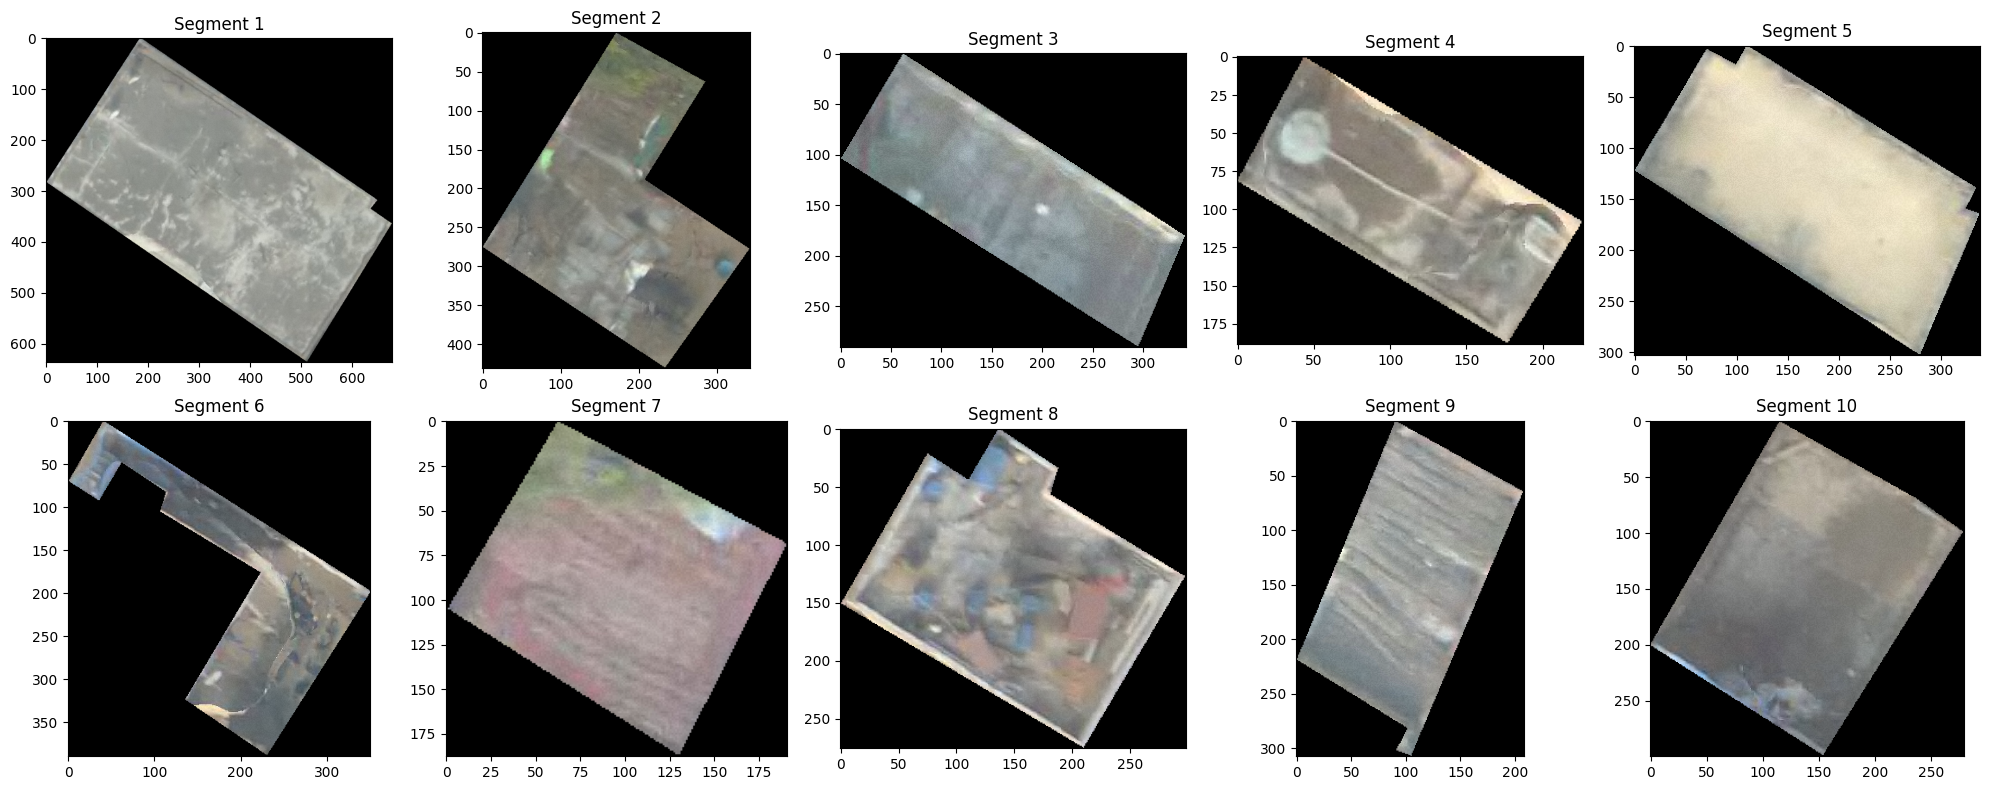

In [11]:

# Plot some of the roof segments
fig, ax = plt.subplots(2, 5, figsize=(20, 8))  # Create a grid of 2x5 plots

for i, segment in enumerate(roof_segments[:10]):  # Plot the first 10 segments
    row = i // 5
    col = i % 5
    
    # Normalize the bands to 0-1 range for plotting
    segment_normalized = np.dstack([segment[j] for j in range(3)])  # Stack the first three bands
    
    # Normalize the bands to the range 0-1
    segment_normalized = (segment_normalized - segment_normalized.min()) / (segment_normalized.max() - segment_normalized.min())

    ax[row, col].imshow(segment_normalized)
    ax[row, col].set_title(f"Segment {i+1}")

plt.tight_layout()
plt.show()

In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from PIL import Image

# Resize function
def resize_images(segments, size=(128, 128)):
    resized_segments = []
    for segment in segments:
        # Convert array to PIL Image for resizing
        img = Image.fromarray((segment[:3].transpose(1, 2, 0) * 255).astype(np.uint8))
        img = img.resize(size, Image.LANCZOS)
        resized_segments.append(np.array(img).transpose(2, 0, 1) / 255.0)  # Normalize to 0-1 and change to C x H x W
    return resized_segments

In [ ]:
# Resize all images
resized_segments = resize_images(roof_segments)

# Convert lists to numpy arrays
resized_segments = np.array(resized_segments)

labels = np.array(labels)

print(np.unique(labels))

# Create a mapping from original labels to zero-indexed labels
label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
print(label_mapping)

# Apply the mapping to your labels
mapped_labels = np.array([label_mapping[label] for label in labels])
print(mapped_labels)
print(mapped_labels.shape)


# Count the number of 1's in mapped_labels
count_of_ones = np.count_nonzero(mapped_labels == 1)
print("Number of 1's in mapped_labels:", count_of_ones)

# Count the number of 1's in mapped_labels
count_of_ones = np.count_nonzero(mapped_labels == 0)
print("Number of 0's in mapped_labels:", count_of_ones)

# Count the number of 1's in mapped_labels
count_of_ones = np.count_nonzero(mapped_labels == 2)
print("Number of 2's in mapped_labels:", count_of_ones)

# Count the number of 1's in mapped_labels
count_of_ones = np.count_nonzero(mapped_labels == 3)
print("Number of 3's in mapped_labels:", count_of_ones)

In [14]:
# Split the dataset into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(resized_segments, mapped_labels, test_size=0.3, random_state=42)


In [15]:
class RoofSegmentDataset(Dataset):
    def __init__(self, segments, labels, transform=None):
        self.segments = segments
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        image = self.segments[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        # Convert image and label to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

# Create training and testing datasets
train_dataset = RoofSegmentDataset(X_train, y_train)
test_dataset = RoofSegmentDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [16]:
import torch.nn as nn
import torch.nn.functional as F


from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)
# Parallelize training across multiple GPUs
model = torch.nn.DataParallel(model)
model = model.to(device)

In [17]:
num_classes = len(np.unique(labels))
print(f"Number of unique classes: {num_classes}")
print(np.unique(labels))

Number of unique classes: 4
[1 2 3 4]


In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:  # Print every 10 batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3f}")
            running_loss = 0.0

print('Finished Training')


In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model.eval()  # Set the model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():  # Turn off gradients for evaluation
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# Print confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)


# Print classification report
class_report = classification_report(all_labels, all_preds, target_names=[str(label) for label in label_mapping.keys()])
print("Classification Report:")
print(class_report)


/home/ai23mtech14008/anaconda3/envs/tan/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Accuracy: 0.9082
Confusion Matrix:
[[1954    3   26   19]
 [   0   91   20    0]
 [  36   10  504   11]
 [ 134    1    7   94]]
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.98      0.95      2002
           2       0.87      0.82      0.84       111
           3       0.90      0.90      0.90       561
           4       0.76      0.40      0.52       236

    accuracy                           0.91      2910
   macro avg       0.86      0.77      0.80      2910
weighted avg       0.90      0.91      0.90      2910



In [24]:
# Count the number of 1's in mapped_labels
count_of_ones = np.count_nonzero(mapped_labels == 1)
print("Number of 1's in mapped_labels:", count_of_ones)

# Count the number of 1's in mapped_labels
count_of_ones = np.count_nonzero(mapped_labels == 0)
print("Number of 0's in mapped_labels:", count_of_ones)

# Count the number of 1's in mapped_labels
count_of_ones = np.count_nonzero(mapped_labels == 2)
print("Number of 2's in mapped_labels:", count_of_ones)

# Count the number of 1's in mapped_labels
count_of_ones = np.count_nonzero(mapped_labels == 3)
print("Number of 3's in mapped_labels:", count_of_ones)

Number of 1's in mapped_labels: 379
Number of 0's in mapped_labels: 6631
Number of 2's in mapped_labels: 1917
Number of 3's in mapped_labels: 772
